# Traffic Flow Optimization
By using QUBO some trial on social problem is broadly solved.
Here we try to solve the optimization of traffic jam.

##References

「Quantum Computing at Volkswagen:  
Traffic Flow Optimization using the D-Wave Quantum Annealer」  
引用：https://www.dwavesys.com/sites/default/files/VW.pdf

##Example
Let's see a simple example that has 9nodes and 12edges of street network.

<img src="https://github.com/mdrft/Wildqat/blob/master/examples_ja/img/017_1.png?raw=1">

## Cars
On the model we put 4 cars on each street and starting point.

<img src="https://github.com/mdrft/Wildqat/blob/master/examples_ja/img/017_2.png?raw=1">




## 3 alternative suggestion for each cars.
We provide 3 possible routes for each cars. Each car adopt just one of it.
Here we prepare totally 12 routes.

<img src="https://github.com/mdrft/Wildqat/blob/master/examples_ja/img/017_3.png?raw=1">

<img src="https://github.com/mdrft/Wildqat/blob/master/examples_ja/img/017_4.png?raw=1">

##Calculate the congestion
The value of the congestion is calculated by the sum of the street appears in the suggested routes.
Finally we get the squaring of the count of the streets to calculate the congestion on QUBO.

<img src="https://github.com/mdrft/Wildqat/blob/master/examples_ja/img/017_5.png?raw=1">

Now we have the total cost as 29, we try to reduce this cost.

##Create QUBO matrix
Now we try to make a cost function of congestion using QUBO matrix.
We need,

1. Cost function to calculate the congestion
2. The constraint term which every car has just one route selected.

<img src="https://render.githubusercontent.com/render/math?math=E%20%3D%20(Q_%7B11%7D%2BQ_%7B12%7D%2BQ_%7B21%7D%2BQ_%7B22%7D)%5E2%20%2B%20(Q_%7B12%7D%2BQ_%7B22%7D%2BQ_%7B43%7D)%5E2%20%2B%20(Q_%7B13%7D%2BQ_%7B23%7D)%5E2%20%2B%20(Q_%7B11%7D%2BQ_%7B21%7D%2BQ_%7B43%7D)%5E2%0D%0A%2B%20(Q_%7B12%7D%2BQ_%7B22%7D%2BQ_%7B43%7D)%5E2%20%2B%20(Q_%7B13%7D%2BQ_%7B23%7D%2BQ_%7B32%7D%2BQ_%7B33%7D)%5E2%20%2B%20(Q_%7B11%7D%2BQ_%7B21%7D%2BQ_%7B33%7D%2BQ_%7B41%7D)%5E2%20%2B%20Q_%7B31%7D%5E2%0D%0A%2B%20(Q_%7B13%7D%2BQ_%7B23%7D%2BQ_%7B32%7D%2BQ_%7B42%7D)%5E2%20%2B%20(Q_%7B11%7D%2BQ_%7B12%7D%2BQ_%7B21%7D%2BQ_%7B22%7D%2BQ_%7B33%7D%2BQ_%7B41%7D%2BQ_%7B43%7D)%5E2%20%2B%20Q_%7B31%7D%5E2%0D%0A%2B%20(Q_%7B13%7D%2BQ_%7B23%7D%2BQ_%7B31%7D%2BQ_%7B32%7D%2BQ_%7B42%7D)%5E2">

Expanding it and we have

<img src="https://render.githubusercontent.com/render/math?math=E%20%3D%204Q_%7B11%7D%5E2%20%2B%204Q_%7B11%7DQ_%7B12%7D%20%2B%208Q_%7B11%7DQ_%7B21%7D%20%2B%204Q_%7B11%7DQ_%7B22%7D%20%2B%204Q_%7B11%7DQ_%7B33%7D%20%2B%204Q_%7B11%7DQ_%7B41%7D%20%2B%204Q_%7B11%7DQ_%7B43%7D%20%2B%204Q_%7B12%7D%5E2%20%2B%204Q_%7B12%7DQ_%7B21%7D%20%2B%208Q_%7B12%7DQ_%7B22%7D%20%2B%202Q_%7B12%7DQ_%7B33%7D%20%2B%202Q_%7B12%7DQ_%7B41%7D%20%2B%206Q_%7B12%7DQ_%7B43%7D%20%2B%204Q_%7B13%7D%5E2%20%2B%208Q_%7B13%7DQ_%7B23%7D%20%2B%202Q_%7B13%7DQ_%7B31%7D%20%2B%206Q_%7B13%7DQ_%7B32%7D%20%2B%202Q_%7B13%7DQ_%7B33%7D%20%2B%204Q_%7B13%7DQ_%7B42%7D%20%2B%204Q_%7B21%7D%5E2%20%2B%204Q_%7B21%7DQ_%7B22%7D%20%2B%204Q_%7B21%7DQ_%7B33%7D%20%2B%204Q_%7B21%7DQ_%7B41%7D%20%2B%204Q_%7B21%7DQ_%7B43%7D%20%2B%204Q_%7B22%7D%5E2%20%2B%202Q_%7B22%7DQ_%7B33%7D%20%2B%202Q_%7B22%7DQ_%7B41%7D%20%2B%206Q_%7B22%7DQ_%7B43%7D%20%2B%204Q_%7B23%7D%5E2%20%2B%202Q_%7B23%7DQ_%7B31%7D%20%2B%206Q_%7B23%7DQ_%7B32%7D%20%2B%202Q_%7B23%7DQ_%7B33%7D%20%2B%204Q_%7B23%7DQ_%7B42%7D%20%2B%203Q_%7B31%7D%5E2%20%2B%202Q_%7B31%7DQ_%7B32%7D%20%2B%202Q_%7B31%7DQ_%7B42%7D%20%2B%203Q_%7B32%7D%5E2%20%2B%202Q_%7B32%7DQ_%7B33%7D%20%2B%204Q_%7B32%7DQ_%7B42%7D%20%2B%203Q_%7B33%7D%5E2%20%2B%204Q_%7B33%7DQ_%7B41%7D%20%2B%202Q_%7B33%7DQ_%7B43%7D%20%2B%202Q_%7B41%7D%5E2%20%2B%202Q_%7B41%7DQ_%7B43%7D%20%2B%202Q_%7B42%7D%5E2%20%2B%204Q_%7B43%7D%5E2%0D%0A">

And we use 12*12 matrix to put all these coefficient in the matrix

<img src="https://github.com/mdrft/Wildqat/blob/master/examples_ja/img/017_6.png?raw=1">

In [0]:
!pip install -U blueqat

In [0]:
import blueqat.wq as wq
import numpy as np
a = wq.Opt()
a.qubo = [
    [4,4,0,8,4,0,0,0,4,4,0,4],
    [0,4,0,4,8,0,0,0,2,2,0,6],
    [0,0,4,0,0,8,2,6,2,0,4,0],
    [0,0,0,4,4,0,0,0,4,4,0,4],
    [0,0,0,0,4,0,0,0,2,2,0,6],
    [0,0,0,0,0,4,2,6,2,0,4,0],
    [0,0,0,0,0,0,3,2,0,0,4,0],
    [0,0,0,0,0,0,0,3,2,0,4,0],
    [0,0,0,0,0,0,0,0,3,4,0,2],
    [0,0,0,0,0,0,0,0,0,2,0,2],
    [0,0,0,0,0,0,0,0,0,0,2,0],
    [0,0,0,0,0,0,0,0,0,0,0,4]
]

##Add constraint term
Every car has only one suggested route.

<img src="https://render.githubusercontent.com/render/math?math=E%20%3D%20K*(Q_%7B11%7D%2BQ_%7B12%7D%2BQ_%7B13%7D-1)%5E2%2BK*(Q_%7B21%7D%2BQ_%7B22%7D%2BQ_%7B23%7D-1)%5E2%2BK*(Q_%7B31%7D%2BQ_%7B32%7D%2BQ_%7B33%7D-1)%5E2%2BK*(Q_%7B41%7D%2BQ_%7B42%7D%2BQ_%7B43%7D-1)%5E2">

expanding it and 

<img src="https://render.githubusercontent.com/render/math?math=E%20%3D%20KQ_%7B11%7D%5E2%20%2B%202KQ_%7B11%7DQ_%7B12%7D%20%2B%202KQ_%7B11%7DQ_%7B13%7D%20-%202KQ_%7B11%7D%20%2B%20KQ_%7B12%7D%5E2%20%2B%202KQ_%7B12%7DQ_%7B13%7D%20-%202KQ_%7B12%7D%20%2B%20KQ_%7B13%7D%5E2%20-%202KQ_%7B13%7D%20%2B%20KQ_%7B21%7D%5E2%20%2B%202KQ_%7B21%7DQ_%7B22%7D%20%2B%202KQ_%7B21%7DQ_%7B23%7D%20-%202KQ_%7B21%7D%20%2B%20KQ_%7B22%7D%5E2%20%2B%202KQ_%7B22%7DQ_%7B23%7D%20-%202KQ_%7B22%7D%20%2B%20KQ_%7B23%7D%5E2%20-%202KQ_%7B23%7D%20%2B%20KQ_%7B31%7D%5E2%20%2B%202KQ_%7B31%7DQ_%7B32%7D%20%2B%202KQ_%7B31%7DQ_%7B33%7D%20-%202KQ_%7B31%7D%20%2B%20KQ_%7B32%7D%5E2%20%2B%202KQ_%7B32%7DQ_%7B33%7D%20-%202KQ_%7B32%7D%20%2B%20KQ_%7B33%7D%5E2%20-%202KQ_%7B33%7D%20%2B%20KQ_%7B41%7D%5E2%20%2B%202KQ_%7B41%7DQ_%7B42%7D%20%2B%202KQ_%7B41%7DQ_%7B43%7D%20-%202KQ_%7B41%7D%20%2B%20KQ_%7B42%7D%5E2%20%2B%202KQ_%7B42%7DQ_%7B43%7D%20-%202KQ_%7B42%7D%20%2B%20KQ_%7B43%7D%5E2%20-%202KQ_%7B43%7D%20%2B%204K">

we make the QUBO matrix

<img src="https://github.com/mdrft/Wildqat/blob/master/examples_ja/img/017_7.jpeg?raw=1">

let's put it into blueqat

In [3]:
k = 10
kk = np.diag([-k for i in range(12)])

for i in range(0,12,3):
  kk[i][i+1] = 2*k
  kk[i][i+2] = 2*k
  kk[i+1][i+2] = 2*k

print(kk)

a.qubo += kk
print(a.qubo)
a.sa()

[[-10  20  20   0   0   0   0   0   0   0   0   0]
 [  0 -10  20   0   0   0   0   0   0   0   0   0]
 [  0   0 -10   0   0   0   0   0   0   0   0   0]
 [  0   0   0 -10  20  20   0   0   0   0   0   0]
 [  0   0   0   0 -10  20   0   0   0   0   0   0]
 [  0   0   0   0   0 -10   0   0   0   0   0   0]
 [  0   0   0   0   0   0 -10  20  20   0   0   0]
 [  0   0   0   0   0   0   0 -10  20   0   0   0]
 [  0   0   0   0   0   0   0   0 -10   0   0   0]
 [  0   0   0   0   0   0   0   0   0 -10  20  20]
 [  0   0   0   0   0   0   0   0   0   0 -10  20]
 [  0   0   0   0   0   0   0   0   0   0   0 -10]]
[[-6 24 20  8  4  0  0  0  4  4  0  4]
 [ 0 -6 20  4  8  0  0  0  2  2  0  6]
 [ 0  0 -6  0  0  8  2  6  2  0  4  0]
 [ 0  0  0 -6 24 20  0  0  4  4  0  4]
 [ 0  0  0  0 -6 20  0  0  2  2  0  6]
 [ 0  0  0  0  0 -6  2  6  2  0  4  0]
 [ 0  0  0  0  0  0 -7 22 20  0  4  0]
 [ 0  0  0  0  0  0  0 -7 22  0  4  0]
 [ 0  0  0  0  0  0  0  0 -7  4  0  2]
 [ 0  0  0  0  0  0  0  0  0 -8 20 2

[0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0]

And correctly we get the result that each cars has just one route.

In [0]:
print(a.E[-1])

-23.0


Let's check the cost function.

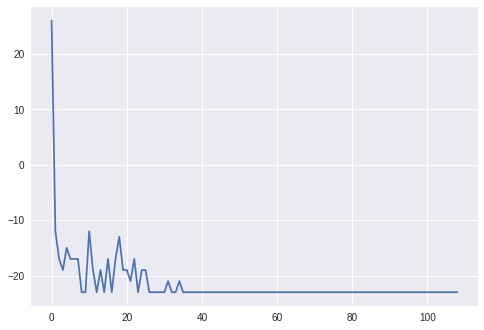

In [0]:
a.plot()